In [62]:
# Homework 4 (due 07/24/2024)
## Arnav Singh

# Decision trees, interpretability, and algorithmic bias

## Objective

In this week's project, you will explore the COMPAS data set. COMPAS stands for "Correctional Offender Management Profiling for Alternative Sanctions". It is a software/algorithm that is used to assess the risk of a registered offender is going to commit another offense. Although researchers and journalists have pointed to [various problems](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of this algorithm over many years, the algorithm is still used to inform sentences and parole decisions in several US states. 
You can learn more about the COMPAS data set [here](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis). 

Through this project, you will practice fitting and validating several classification models and you will explore some distinct benefits of using decision trees in machine learning. As part of that exploration, you are going to audit your model for demographic biases via a "closed box" and an "open box" approach.

The COMPAS data set is a favorite example among critics of machine learning because it demonstrates several shortcomings and failure modes of machine learning techniques. The lessons learned from this project might be discouraging, and they are important. Keep in mind, however, that what you see here does not generalize to all data sets. 

This project has four parts.

### Part 1: Prepare the COMPAS data set  (PARTIALLY YOU TO COMPLETE)

In this part, you will load the COMPAS data set, explore its content, and select several variables as features (i.e., queries) or class labels (i.e., responses). Some of these features are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include categorical variable with more than two categories. You will uses 1-hot encoding to include this feature in your data set. 

This part includes four steps:
1. Load and explore data set
2. Select features and response variables
3. Construct numerical coding for categorical features
4. Split the data

### Part 2: Train and validate a decision tree  (PARTIALLY YOU TO COMPLETE)

In this part, you will fit a decision tree to your data. You will examine the effect of tuning the complexity of the tree via the "maximum number of leaves" parameter and use 5-fold cross-validation to find an optimal value.

This part includes three steps:

1. Fit a decision tree on the training data
2. Tune the parameter "maximum number of leaves"
3. Calculate the selected model's test performance


### Part 3: Auditing a decision tree for demographic biases  (PARTIALLY YOU TO COMPLETE)

Your training data includes several demographic variables (i.e., age, sex, race). A crude way to assess whether a model has some demographic bias is to remove the corresponding variables from your training data and explore how that removal affects your model's performance. Decision trees have the advantage of being interpretable machine learning models. By going through the decision nodes (i.e., branching points), you can "open the black box and look inside". Specifically, you can assess how each feature is used in the decision making process.

This part includes three steps:

1. Fit a decision tree
2. Check for racial bias via performance assessment
3. Check for racial bias via decision rules

### Part 4: Comparison to other linear classifiers (FOR YOU TO COMPLETE)

For some types of data, decision trees tend to achieve lower prediction accuracies In this part, you will train and tune several classifiers on the COMPAS data. You will then compare their performance on your test set.

This part includes three steps:

1. Fit LDA and logistic regression
2. Tune and fit ensemble methods
3. Tune and fit SVC
4. Compare performance metrics for all models 

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

## Part 1: Prepare the COMPAS data set

>In this part, you will load the COMPAS data set, explore its content, and select several variables as features (i.e., queries) or class labels (i.e., responses). Some of these features are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include categorical variable with more than two categories. You will uses 1-hot encoding to include this feature in your data set.
>
>This part includes four steps:
>1. Load and explore data set
>2. Select features and response variables
>3. Construct numerical coding for categorical features
>4. Split the data



### Part 1, Step 1: Load and explore data set

This folder includes the 'compas-scores-two-years.csv' file. The COMPAS data that you will use for this project is in this file. It is always a good idea to look at the raw data before proceeding with one's machine learning pipeline.

In [64]:
# load data
raw_data = pd.read_csv('compas-scores-two-years.csv') # downloaded the dataset
# print a list of variable names
print(raw_data.columns)
# look at the first 5 rows 
raw_data.head(5)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


The data set includes 53 variables. There are different types of information. Some variables
* personal data (e.g., name, first name ("first"), last name ("last")) 
* demographic data (i.e., sex, age, age category ("age_cat"), and race)
* related to the person's history of commited offenses (e.g., juvenile felony count ("juv_fel_count"), juvenile misdemeanor count ("juv_misd_count"), and prior offenses count ("priors-count"))
* related to the charge against the person (e.g., charge offense date ("c_offense_date"), charge arrest date ("c_arrest_date"), charge degree ("c_charge_degree"), and description of charge ("c_charge_desc"))
* recidivism scores assigned by the COMPAS algorithm (e.g., "decile_score", "score_text", "v_decile_score", "v_score_text")
* related to an actual recidivism charge (e.g., degree of recidivism charge ("r_charge_degree"), data of recidivism offense ("r_offense_date"), description of recidivism charge ("r_charge_desc"))
* related to an actual violent recidivism charge (e.g., degree of violent recidivism charge ("vr_charge_degree"), data of violent recidivism offense ("vr_offense_date"), description of violent recidivism charge ("vr_charge_desc")).

### Part 1, Step 2: Select features and response variables

The ProPublica article was assessing bias in the COMPAS scores. Here, you will ignore the COMPAS scores and instead explore the challenges of predicting recidivism based on the survey data. What variables seem like sensible predictors? What variables would be sensible outcome variables? The code in the cell below selects some numerical and categorical variables for you to include in your model.

> Some of the variable that seem like sensibile preidctors could be the ones associated with previous crime entanglements, such as juvenile felony count ("juv_fel_count"), juvenile misdemeanor count ("juv_misd_count"), and prior offenses count ("priors-count"). There is other info that could play a role, such as age, gender, race. Some sensible outcome variables are the degree of recidivism, the data associated with it, such as the date of recidism and its desrciption. 

In [65]:
# Select features and response variables

# Features by type
numerical_features = ['juv_misd_count', 'juv_other_count', 'juv_fel_count', 
    'priors_count', 'age']
binary_categorical_features = ['sex', 'c_charge_degree']
other_categorical_features = ['race']
all_features = binary_categorical_features + other_categorical_features + numerical_features

# Possible response variables
response_variables = ['is_recid', 'is_violent_recid', 'two_year_recid']

# Variables that are used for data cleaning
check_variables = ['days_b_screening_arrest']

ProPublica filtered some observations (i.e., rows in the data frame). See their explanation below. Let's follow their procedure.


> There are a number of reasons remove rows because of missing data:
>
> * If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
> * We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
> * In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
> * We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.


In [66]:
# Subselect data
df = raw_data[all_features+response_variables+check_variables]

# Apply filters
df = df[(df['days_b_screening_arrest'] <= 30) & 
        (df['days_b_screening_arrest'] >= -30) & 
        (df['is_recid'] != -1) & 
        (df['c_charge_degree'] != 'O')]

df = df[all_features+response_variables]
print('Dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

Dataframe has 6172 rows and 11 columns.


### Part 1, Step 3: Construct numerical coding for categorical features

Some of these features in the subselected data are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include "race", which was surveyed as a one categorical variable with more than two categories. You will uses [1-hot encoding](https://en.wikipedia.org/wiki/One-hot) to include this feature in your data set. 

In [67]:
# Code binary features as 0 and 1
for x in binary_categorical_features:
    for new_value, value in enumerate(set(df[x])):
        print("Replace {} with {}.".format(value, new_value))
        df = df.replace(value, new_value)

Replace Male with 0.
Replace Female with 1.
Replace M with 0.
Replace F with 1.


In [68]:
# Use 1-hot encoding for other categorical variables ## Makes it like boolean, for each category. 
one_hot_features = []
for x in other_categorical_features:
    for new_feature, value in enumerate(set(df[x])):
        feature_name = "{}_is_{}".format(x,value)
        df.insert(3, feature_name, df[x]==value)
        one_hot_features += [feature_name]

# Check what the data frame looks like now
df.head(10)

,sex,c_charge_degree,race,race_is_African-American,race_is_Asian,race_is_Other,race_is_Hispanic,race_is_Native American,race_is_Caucasian,juv_misd_count,juv_other_count,juv_fel_count,priors_count,age,is_recid,is_violent_recid,two_year_recid
0,0,1,Other,False,False,True,False,False,False,0,0,0,0,69,0,0,0
1,0,1,African-American,True,False,False,False,False,False,0,0,0,0,34,1,1,1
2,0,1,African-American,True,False,False,False,False,False,0,1,0,4,24,1,0,1
5,0,0,Other,False,False,True,False,False,False,0,0,0,0,44,0,0,0
6,0,1,Caucasian,False,False,False,False,False,True,0,0,0,14,41,1,0,1
7,0,1,Other,False,False,True,False,False,False,0,0,0,3,43,0,0,0
8,1,0,Caucasian,False,False,False,False,False,True,0,0,0,0,39,0,0,0
10,0,1,Caucasian,False,False,False,False,False,True,0,0,0,0,27,0,0,0
11,0,0,African-American,True,False,False,False,False,False,0,0,0,3,23,1,0,1
12,1,0,Caucasian,False,False,False,False,False,True,0,0,0,0,37,0,0,0


### Part 1, Step 4: Split the data

Let's collect the features in one data frame and the responses in another data frame. After that, you will set a small portion of the data set aside for testing.

In [69]:
# list of features
features = numerical_features + binary_categorical_features + one_hot_features

# features data frame
X = df[features]

# responses data frame
Y = df[response_variables]

# Split the data into a training set containing 90% of the data
# and test set containing 10% of the data
'''ADD SOME CODE HERE'''
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

# Part 2: Train and validate a decision tree

>In this part, you will fit a decision tree to your data. You will examine the effect of tuning the complexity of the tree via the "maximum number of leaves" parameter and use 5-fold cross-validation to find an optimal value.
>
>This part includes three steps:
>
>1. Fit a decision tree on the training data
>2. Tune the parameter "maximum number of leaves"
>3. Calculate the selected model's test performance

### Part 2, Step 1: Fit a decision tree on the training data

Start by fitting a decision tree to your training data. Assess its training accuracy and its size.

In [70]:
# Create a model
'''ADD SOME CODE HERE'''
dtc = DecisionTreeClassifier()
    
# Fit model to training data
'''ADD SOME CODE HERE'''
dtc.fit(x_train, y_train)

# Evaluate training accuracy
'''ADD SOME CODE HERE'''
from sklearn.metrics import accuracy_score #importing
train_results = dtc.predict(x_train)
accuracy = accuracy_score(y_train, train_results)

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 2016 leaves and training accuracy 0.80.


Your tree has a good training accuracy for the standards of tabular data prediction problems, but its size is enormous! It has so many leaves, that on average every 3 to 4 training observations get a leaf to themselves. It is very probable that this tree is overfitting.

### Part 2, Step 2: Tune the parameter "maximum number of leaves"

Let's try to constrain the complexity of a decision tree during training by setting a value for the argument ``maximum number of leaves``. You can use the sci-kit learn's `cross_val_score` function to quickly assess the out-of-sample performance of trees of varying complexity.

In [71]:
max_score = 0
best_leaves = 0
# Perform 5-fold cross-validation for different tree sizes
print('Leaves\tMean accuracy')
print('---------------------')
for num_leaves in range(2,1800): #starting with 2 leaves anyways, and incrementing by 1

    # Trees must have at least 2 leaves
    if num_leaves >= 2:

        # construct a classifier with a limit on its number of leaves
        '''ADD SOME CODE HERE'''
        dtc = DecisionTreeClassifier(max_leaf_nodes=num_leaves)

        # Get validation accuracy via 5-fold cross-validation
        scores = cross_val_score(dtc, x_train, y_train, cv=5, scoring='accuracy') #cv=5 means 5-fold cross validation
        if(scores.mean() > max_score):
            max_score = scores.mean()
            best_leaves = num_leaves
        
    #print("{}\t{:.3f}".format(num_leaves,scores.mean())) # no need to see this right now, takes up a lot of space
print("Best Accuracy was {} with score of {:.3f}".format(best_leaves, max_score))

Leaves	Mean accuracy
---------------------
Best Accuracy was 16 with score of 0.593


Adjust the range of values for `max_leaf_nodes` in the cell above, to identify the best value.
- Looking at the range of values, it looks like the number of leaves changes everytime when running, so beast_leaves tracks it for us. 

### Part 2, Step 3: Calculate the selected model's test performance

Train a decision tree using your selected value of `max_leaf_nodes` on the full training set. Assess its accuracy on your test set.

In [72]:
# Create a model
'''ADD SOME CODE HERE'''
dtc2 = DecisionTreeClassifier(max_leaf_nodes=best_leaves)    
# Fit model to training data
'''ADD SOME CODE HERE'''
dtc2.fit(x_train, y_train)
# Evaluate training accuracy
'''ADD SOME CODE HERE'''
train_results = dtc2.predict(x_train)
accuracy = accuracy_score(y_train, train_results)
print(f'Trained decision tree with {accuracy:.5f} accuracy') # checking the rest of the decimal
# Check size of decision tree
'''ADD SOME CODE HERE'''
num_leaves = dtc2.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and test accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 0.60857 accuracy
Trained decision tree with 16 leaves and test accuracy 0.61.


# Part 3: Auditing a decision tree for demographic biases

>Your training data includes several demographic variables (i.e., age, sex, race). A crude way to assess whether a model has some demographic bias is to remove the corresponding variables from your training data and explore how that removal affects your model's performance. Decision trees have the advantage of being interpretable machine learning models. By going through the decision nodes (i.e., branching points), you can "open the black box and look inside". Specifically, you can assess how each feature is used in the decision making process.
>
>This part includes two steps:
>
>1. Check for racial bias via performance assessment
>2. Check for racial bias via decision rules
  
### Part 3, Step 2: Check for racial bias via performance assessment
A simple approach to identifying demographic biases in machine learning is the following: (i) Train and validate the model on the full training set, (ii) train and validate the model on a subset of training variables that excludes the variables related to a potential demographic bias, (iii) compare the results. 

You have noticed that the validation accuracy of your model can vary for different holdout set selections. To account for these variations, you are going to compare the mean validation accuracy over 100 trees. (You have completed (i) in the previous cell already. Continue now with (ii).)

In [73]:
# Create subset of training data without information on race. 
# (The information on race was encoded in the one-hot features.)
remaining_features = [v for v in X.columns if v not in one_hot_features]
X_train_sub = x_train[remaining_features]
X_test_sub = x_test[remaining_features]

# Create a model
dtc = DecisionTreeClassifier(max_leaf_nodes=best_leaves)
    
# Fit model to training data
dtc.fit(X_train_sub, y_train['two_year_recid'])

# Evaluate training accuracy
y_pred = dtc.predict(X_test_sub)
accuracy = (y_pred == y_test['two_year_recid']).mean()

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and test accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 16 leaves and test accuracy 0.65.


Comparing the mean accuracy values on the all features versus the subselected feature set, what do you conclude about the importance of racial information in this classification problem?
- The accuracy of the subselected feature set increases when the racial information is removed, suggesting that racial information leads to an overfitting or bad representation of the data. 

### Part 3, Step 3: Check for racial bias via decision rules
The interpretability of decision trees allows for an alternative approach to detecting racial bias. You can simply look at the decision rules. Use the scit-kit learn's function `export_text` to get your decision tree in text format. Compare the decision rules of the your tree with all features and your tree fitted on the subset without racial information. Do you find any indication of racial bias in the decision rules of the first tree?

In [74]:
'''ADD SOME CODE HERE'''
## Tree with all the features
tree_rules_with_race = export_text(dtc2, feature_names=features)
print("Decision rules with Racial Information:\n")
print(tree_rules_with_race)

## Tree without racial information
print("Decision rules without Racial Information:\n")
tree_rules_without_race = export_text(dtc, feature_names=remaining_features)
print(tree_rules_without_race)

Decision rules with Racial Information:

|--- priors_count <= 1.50
|   |--- age <= 22.50
|   |   |--- age <= 20.50
|   |   |   |--- class: 1
|   |   |--- age >  20.50
|   |   |   |--- sex <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- sex >  0.50
|   |   |   |   |--- class: 1
|   |--- age >  22.50
|   |   |--- age <= 35.50
|   |   |   |--- priors_count <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  0.50
|   |   |   |   |--- class: 1
|   |   |--- age >  35.50
|   |   |   |--- priors_count <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  0.50
|   |   |   |   |--- class: 1
|--- priors_count >  1.50
|   |--- age <= 33.50
|   |   |--- priors_count <= 7.50
|   |   |   |--- age <= 21.50
|   |   |   |   |--- class: 1
|   |   |   |--- age >  21.50
|   |   |   |   |--- priors_count <= 2.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- priors_count >  2.50
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- class: 1
|   

### Did you find any indication of racial bias in the decision rules of the first tree?
No there looks to be no racial bias in the decision rules of the first tree, indicating that the optimal model has nothing with race.

# Part 4: Comparison to other linear classifiers

>For some types of data, decision trees tend to achieve lower prediction accuracies In this part, you will train and tune several classifiers on the COMPAS data. You will then compare their performance on your test set.
>
>This part includes three steps:
>
>1. Fit LDA and logistic regression
>2. Tune and fit ensemble methods
>3. Tune and fit SVC
>4. Compare test accuracy of all your models 

### 1. LDA and logistic regression

In [75]:
## Importing the necessary packages
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Fitting LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train['two_year_recid'])
lda_predictions = lda.predict(x_test)
lda_accuracy = accuracy_score(y_test['two_year_recid'], lda_predictions)
print(f'Linear Discriminant Analysis Test Accuracy: {lda_accuracy:.5f}')

# Fitting Logistic Regression
logReg = LogisticRegression(max_iter=500)
logReg.fit(x_train, y_train['two_year_recid'])
logReg_predictions = logReg.predict(x_test)
logReg_accuracy = accuracy_score(y_test['two_year_recid'], logReg_predictions)
print(f'Logistic Regression Test Accuracy: {logReg_accuracy:.5f}')

Linear Discriminant Analysis Test Accuracy: 0.64078
Logistic Regression Test Accuracy: 0.64401


### 2. Tune and fit Ensemble Methods
> We have the main categories of Bagging, Boosting, and Random Forest. So I choose a little bit more, with Bagging, AdaBoosting, Gradient Boosting, Random Forest, Extra Trees, and Voting Classifier to just see.

In [76]:
## this takes some time
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    BaggingClassifier, 
    ExtraTreesClassifier, 
    VotingClassifier
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Random Forest
rf = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(x_train, y_train['two_year_recid'])
rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(x_test)
rf_accuracy = accuracy_score(y_test['two_year_recid'], rf_preds)
print(f'Random Forest Test Accuracy: {rf_accuracy:.4f}')

# Gradient Boosting
gb = GradientBoostingClassifier()
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='accuracy')
gb_grid.fit(x_train, y_train['two_year_recid'])
gb_best = gb_grid.best_estimator_
gb_preds = gb_best.predict(x_test)
gb_accuracy = accuracy_score(y_test['two_year_recid'], gb_preds)
print(f'Gradient Boosting Test Accuracy: {gb_accuracy:.4f}')

# AdaBoost
ada = AdaBoostClassifier()
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
ada_grid = GridSearchCV(ada, ada_params, cv=5, scoring='accuracy')
ada_grid.fit(x_train, y_train['two_year_recid'])
ada_best = ada_grid.best_estimator_
ada_preds = ada_best.predict(x_test)
ada_accuracy = accuracy_score(y_test['two_year_recid'], ada_preds)
print(f'AdaBoost Test Accuracy: {ada_accuracy:.4f}')

# Bagging
bag = BaggingClassifier()
bag_params = {'n_estimators': [50, 100, 200], 'max_samples': [0.5, 0.7, 1.0], 'max_features': [0.5, 0.7, 1.0]}
bag_grid = GridSearchCV(bag, bag_params, cv=5, scoring='accuracy')
bag_grid.fit(x_train, y_train['two_year_recid'])
bag_best = bag_grid.best_estimator_
bag_preds = bag_best.predict(x_test)
bag_accuracy = accuracy_score(y_test['two_year_recid'], bag_preds)
print(f'Bagging Test Accuracy: {bag_accuracy:.4f}')

# Extra Trees
et = ExtraTreesClassifier()
et_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
et_grid = GridSearchCV(et, et_params, cv=5, scoring='accuracy')
et_grid.fit(x_train, y_train['two_year_recid'])
et_best = et_grid.best_estimator_
et_preds = et_best.predict(x_test)
et_accuracy = accuracy_score(y_test['two_year_recid'], et_preds)
print(f'Extra Trees Test Accuracy: {et_accuracy:.4f}')

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best), 
        ('gb', gb_best), 
        ('ada', ada_best), 
        ('bag', bag_best), 
        ('et', et_best)
    ],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted probabilities
)

voting_clf.fit(x_train, y_train['two_year_recid'])
voting_preds = voting_clf.predict(x_test)
voting_accuracy = accuracy_score(y_test['two_year_recid'], voting_preds)
print(f'Voting Classifier Test Accuracy: {voting_accuracy:.4f}')

Random Forest Test Accuracy: 0.6553
Gradient Boosting Test Accuracy: 0.6634
AdaBoost Test Accuracy: 0.6634
Bagging Test Accuracy: 0.6214
Extra Trees Test Accuracy: 0.6375
Voting Classifier Test Accuracy: 0.6602


### 3. Tune and fit SVC

In [77]:
# Initialize the Support Vector Classifier, this also takes time to go through
svc = SVC() 
# Define the hyperparameters and their possible values to be searched during Grid Search
svc_params = {'C': [0.1, 1, 10],  # 'C' is the regularization parameter. A smaller 'C' makes the decision surface smoother, while a larger 'C' aims to classify all training examples correctly. Here we test 0.1, 1, and 10.
'kernel': ['linear', 'rbf'],  # 'kernel' specifies the kernel type to be used in the algorithm.
                                  # 'linear' is for linear kernel, 'rbf' is for the Radial Basis Function kernel.
'gamma': ['scale', 'auto']  # 'gamma' defines how far the influence of a single training example reaches, 
                                # with low values meaning 'far' and high values meaning 'close'.
                                # 'scale' uses 1 / (n_features * X.var()) as the value of gamma.
                                # 'auto' uses 1 / n_features.
}
# Initialize GridSearchCV to perform an exhaustive search over specified parameter values for the SVC model
svc_grid = GridSearchCV(
    svc,  # The estimator or model to be optimized, in this case, the Support Vector Classifier
    svc_params,  # Dictionary of parameters to search, as defined above
    cv=5,  # Number of cross-validation folds, here 5-fold cross-validation is used
    scoring='accuracy'  # The performance metric to evaluate the models, here 'accuracy' is used
)

# Fit the GridSearchCV to the training data to find the best hyperparameter combination
svc_grid.fit(x_train, y_train['two_year_recid'])
# 'y_train['two_year_recid']' contains the target variable, indicating whether a two-year recidivism event occurred

# Retrieve the best estimator found by GridSearchCV after fitting
svc_best = svc_grid.best_estimator_

# Use the best model to make predictions on the test data
svc_preds = svc_best.predict(x_test)
# 'svc_preds' will store the predicted labels for the test set
# Calculate the accuracy score of the predictions against the true test labels
svc_accuracy = accuracy_score(y_test['two_year_recid'], svc_preds)
# 'y_test['two_year_recid']' contains the actual labels for the test data
# 'accuracy_score' computes the ratio of correctly predicted labels to the total number of predictions
# Print the accuracy score, formatted to four decimal places
print(f'SVC Test Accuracy: {svc_accuracy:.4f}')

SVC Test Accuracy: 0.6375


### 4. Comparing all Models 


Model Accuracies Sorted by Performance:
                 Model  Accuracy
4    Gradient Boosting  0.663430
5             AdaBoost  0.663430
8    Voting Classifier  0.660194
3        Random Forest  0.655340
0        Decision Tree  0.652104
2  Logistic Regression  0.644013
1                  LDA  0.640777
7          Extra Trees  0.637540
9                  SVC  0.637540
6              Bagging  0.621359


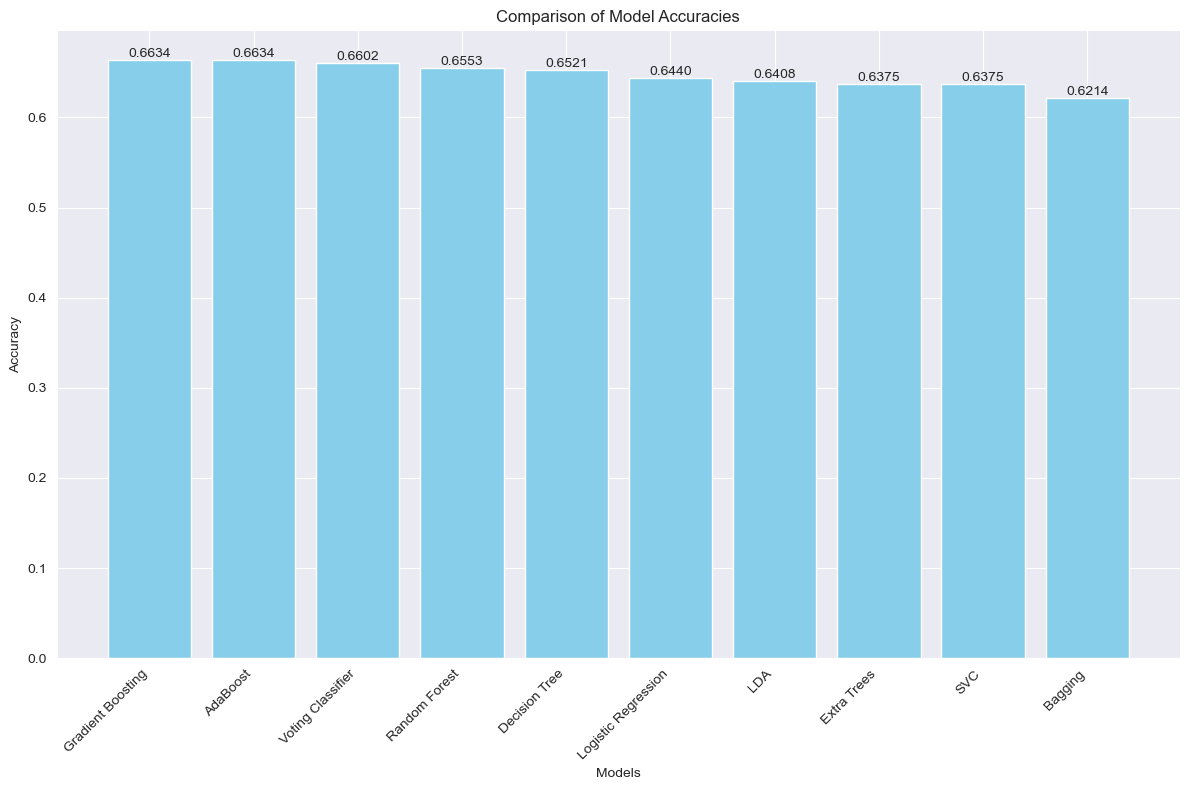

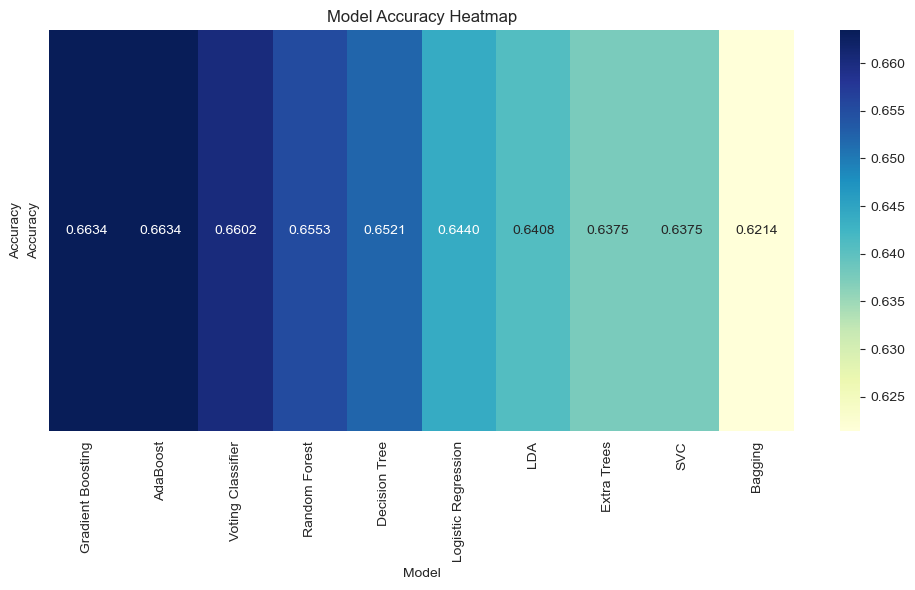

In [78]:
#Printing all the accuracies to compare all models
# Create a DataFrame to store model names and their accuracies
accuracy_df = pd.DataFrame({
    'Model': [
        'Decision Tree', 
        'LDA', 
        'Logistic Regression', 
        'Random Forest', 
        'Gradient Boosting', 
        'AdaBoost', 
        'Bagging', 
        'Extra Trees', 
        'Voting Classifier', 
        'SVC'
    ],
    'Accuracy': [
        accuracy, 
        lda_accuracy, 
        logReg_accuracy, 
        rf_accuracy, 
        gb_accuracy, 
        ada_accuracy, 
        bag_accuracy, 
        et_accuracy, 
        voting_accuracy, 
        svc_accuracy
    ]
})

# Sort the DataFrame by Accuracy in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Display the DataFrame
print("\nModel Accuracies Sorted by Performance:")
print(accuracy_df)

### Now Visualizating the Plot
# Create a bar chart to visualize model accuracies
plt.figure(figsize=(12, 8))  # Set the figure size for better readability
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue')  # Plot a bar for each model

# Add labels and title to the plot
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add accuracy values on top of the bars
for index, value in enumerate(accuracy_df['Accuracy']):
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()
### HeatMap idea
import seaborn as sns

# Create a heatmap to visualize the model accuracies
plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df.set_index('Model').T, annot=True, cmap='YlGnBu', fmt=".4f")

# Set titles and labels
plt.title('Model Accuracy Heatmap')
plt.ylabel('Accuracy')

# Show the plot
plt.tight_layout()
plt.show()

### Analysis
Comparing all the model accuracies, it is interesting to see that everytime the code is re-run, the models switch places with each other. Sometimes the worst is Bagging, RF, and Decision Tree, and sometimes they are some of the best. However, a constant is that these models only differ by +-4% at most, but no one model is entirely repeatable.